# PML Project


Update Date: 2022-01-11

Author: Jiajun He & Xiqing Mao

Content: Compare Epoch VS recon.acc & Epoch VS rho


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Task 1: Implement DeepSequence VAE model


In [1]:
%%capture
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta    
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
!pip install biopython

import helper
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
import pandas as pd
from collections import Counter
from scipy.stats import spearmanr

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

dataset, weights = helper.get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_weighted = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=len(dataset)))
experimental_data = helper.read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset)

## 1.1 Implement a standard VAE

In [2]:
class standard_VAE(nn.Module):
    def __init__(self, input_size, latent_size, device):
        super().__init__()
        self.fc11 = nn.Linear(input_size, 1500) # 1500 is the number in the papar
        self.fc12 = nn.Linear(1500, 1500)
        self.fc131 = nn.Linear(1500, latent_size)
        self.fc132 = nn.Linear(1500, latent_size)

        self.fc21 = nn.Linear(latent_size, 100)
        self.fc22 = nn.Linear(100, 2000)
        self.fc23 = nn.Linear(2000, input_size)

        self.device = device
    
    def encoder(self, x):
        x = nn.functional.one_hot(x, num_classes=23).float().reshape(x.shape[0], -1)
        hidden = nn.ReLU()(self.fc11(x))
        hidden = nn.ReLU()(self.fc12(hidden))
        z_mu = self.fc131(hidden)
        z_sd = torch.exp(self.fc132(hidden))

        return z_mu, z_sd

    def decoder(self, z):
        hidden = nn.ReLU()(self.fc21(z))
        hidden = nn.ReLU()(self.fc22(hidden))
        x = self.fc23(hidden)

        return x.reshape(z.shape[0], -1, 23)
    
    def forward(self, x, mc_samples=1):
        z_mu, z_sd = self.encoder(x)

        # prior distribution
        prior = torch.distributions.Normal(0., 1.)
        posterior = torch.distributions.Normal(z_mu, z_sd)

        # since both prior and posterior are diag-Gaussian, the KL divergence between q(z|x) and p(z) is just the sum of the KL divergence in each dimension
        KL_post_prior = torch.sum(torch.distributions.kl.kl_divergence(posterior, prior), dim=-1)

        # E_q[p(x|z)] (sum because p(x|z) = p(x1|z)p(x2|z)...)
        z = torch.randn_like(z_mu) * z_sd + z_mu
        x_logit = self.decoder(z)
        Ep = torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        for sample in range(mc_samples-1):
            z = torch.randn_like(z_mu) * z_sd + z_mu
            x_logit = self.decoder(z)
            Ep += torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        Ep = Ep / mc_samples
        ELBO = torch.sum(Ep - KL_post_prior)
        return ELBO, z_mu, z_sd

## 1.2 Visualize the z-space

In [3]:
def train(model, dl, optimizer, device):
    ELBOs = []
    for i in dl:
        optimizer.zero_grad()
        ELBO, _, _ = model(i[0].to(device))
        loss = -ELBO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        ELBOs.append(ELBO.item())
    return sum(ELBOs) / len(ELBOs)

In [ ]:
# train the model
input_size = next(iter(dataloader))[0].shape[1] * 23
standard_vae_dim_2 = standard_VAE(input_size, 2, device=DEVICE).to(DEVICE)
EPOCH = 180
ELBOs = [train(standard_vae_dim_2, dataloader, Adam(standard_vae_dim_2.parameters(), lr=0.001), DEVICE) for epoch in tqdm(range(EPOCH))]

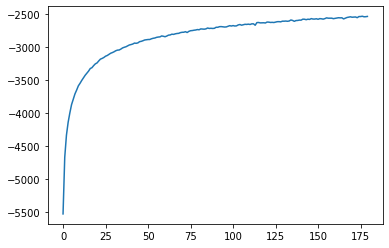

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae_dim_2.pkl"
# #torch.save(standard_vae_dim_2.state_dict(),PATH)
# standard_vae_dim_2.load_state_dict(torch.load(PATH))

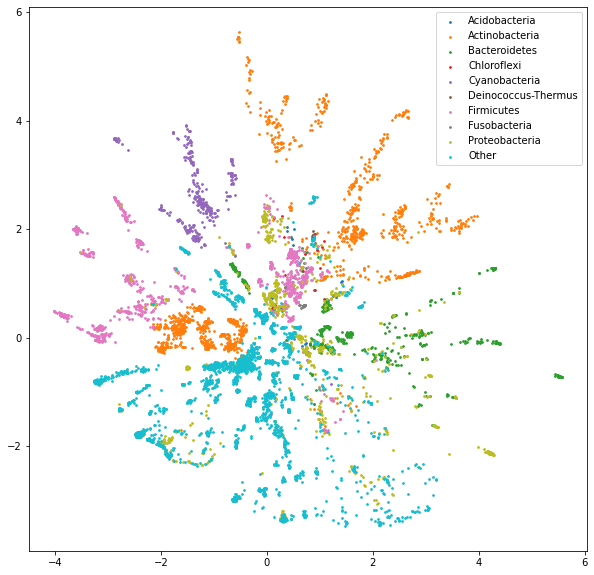

In [5]:
Zs = []
labels = []
with torch.no_grad():
    for i in dataloader:
        z_mu, _ = standard_vae_dim_2.encoder((i[0].to(DEVICE)))
        Zs.append(z_mu.cpu())
        labels.append(i[1])
Zs = torch.cat(Zs).numpy()
labels = torch.cat(labels).numpy()

plt.rcParams["figure.figsize"] = (10, 10)
for idx, name in enumerate(helper.phyla):
    plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
plt.legend()
plt.show()

## 1.3  Quantitative assessment

In [ ]:
# trend
input_size = next(iter(dataloader))[0].shape[1] * 23
standard_vae = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

EPOCH = 180
ELBOs = []
accs = []
correlations = []
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train(standard_vae, dataloader, Adam(standard_vae.parameters(), lr=1e-4), DEVICE))
    if epoch in range(10, EPOCH, 10):
        acc = helper.check_reconstruct(dataset, standard_vae)
        accs.append(acc)
        correlation = helper.quantitative_assessment(dataset, standard_vae, experimental_data, 20)
        correlations.append(correlation)
        print(acc, correlation)

  6%|▌         | 11/180 [02:59<2:00:59, 42.96s/it]

0.7856844397306411 SpearmanrResult(correlation=0.4695360150146036, pvalue=1.7435267043896252e-272)


 12%|█▏        | 21/180 [05:53<1:54:11, 43.09s/it]

0.8307398258434918 SpearmanrResult(correlation=0.42192283683982285, pvalue=6.2297154244771e-215)


 17%|█▋        | 31/180 [08:47<1:47:40, 43.36s/it]

0.8585177113407259 SpearmanrResult(correlation=0.4050053504521709, pvalue=1.308779844718243e-196)


 23%|██▎       | 41/180 [11:41<1:39:51, 43.11s/it]

0.878302759320049 SpearmanrResult(correlation=0.28288176979685287, pvalue=1.3617597789253742e-92)


 28%|██▊       | 51/180 [14:35<1:32:58, 43.24s/it]

0.8951890767300767 SpearmanrResult(correlation=0.23100561094439415, pvalue=1.603431355101778e-61)


 34%|███▍      | 61/180 [17:29<1:25:32, 43.13s/it]

0.9093991581078172 SpearmanrResult(correlation=0.27462999106900915, pvalue=3.608318258201212e-87)


 39%|███▉      | 71/180 [20:23<1:18:28, 43.20s/it]

0.9219659791795526 SpearmanrResult(correlation=0.2588794083029179, pvalue=2.489967384964311e-77)


 45%|████▌     | 81/180 [23:16<1:10:44, 42.87s/it]

0.933101370256116 SpearmanrResult(correlation=0.2945519344969135, pvalue=1.388128247740608e-100)


 51%|█████     | 91/180 [26:10<1:04:19, 43.36s/it]

0.942867862481895 SpearmanrResult(correlation=0.3211176242846923, pvalue=3.187461516334763e-120)


 56%|█████▌    | 101/180 [29:04<56:36, 42.99s/it] 

0.9523832606550161 SpearmanrResult(correlation=0.24075038844056915, pvalue=8.072450720359416e-67)


 62%|██████▏   | 111/180 [31:57<49:24, 42.96s/it]

0.9608375683237581 SpearmanrResult(correlation=0.3901072454253942, pvalue=2.4813140481803745e-181)


 67%|██████▋   | 121/180 [34:51<42:16, 42.98s/it]

0.9686030639291275 SpearmanrResult(correlation=0.37900640868250185, pvalue=1.8852145948762587e-170)


 73%|███████▎  | 131/180 [37:44<35:06, 43.00s/it]

0.974995298045732 SpearmanrResult(correlation=0.427295034150717, pvalue=5.651735507352748e-221)


 78%|███████▊  | 141/180 [40:37<27:45, 42.71s/it]

0.9794849372652659 SpearmanrResult(correlation=0.42596967035953903, pvalue=1.7909673783331153e-219)


 84%|████████▍ | 151/180 [43:29<20:34, 42.56s/it]

0.9833468413531545 SpearmanrResult(correlation=0.43230560186929207, pvalue=1.0395723412133628e-226)


 89%|████████▉ | 161/180 [46:23<13:33, 42.81s/it]

0.9864040811024095 SpearmanrResult(correlation=0.4331165237030079, pvalue=1.2008425250145576e-227)


 95%|█████████▌| 171/180 [49:16<06:25, 42.86s/it]

0.9887671766752045 SpearmanrResult(correlation=0.43365823854730284, pvalue=2.8305635064610885e-228)


100%|██████████| 180/180 [50:02<00:00, 16.68s/it]


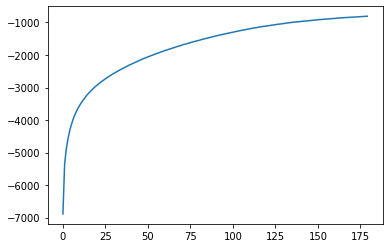

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

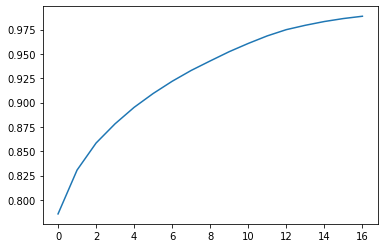

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(accs)
plt.show()

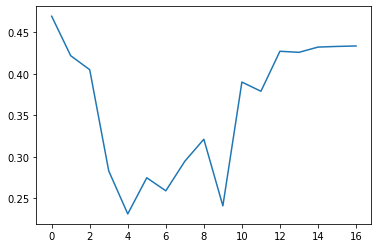

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.array([[j for j in i] for i in correlations]).T[0])
plt.show()

In [ ]:
# single result, 50
helper.quantitative_assessment(dataset, standard_vae, experimental_data, 50)

SpearmanrResult(correlation=0.5031516430567009, pvalue=0.0)

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae.pkl"
# #torch.save(standard_vae.state_dict(),PATH)
# standard_vae.load_state_dict(torch.load(PATH))

## 1.4 Sequence reweighting

### 1.4.1

In [ ]:
# trend
input_size = next(iter(dataloader_weighted))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

EPOCH = 180
ELBOs = []
accs = []
correlations = []
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train(standard_vae_weighted, dataloader_weighted, Adam(standard_vae_weighted.parameters(), lr=1e-4), DEVICE))
    if epoch in range(10, EPOCH, 10):
        acc = helper.check_reconstruct(dataset, standard_vae_weighted)
        accs.append(acc)
        correlation = helper.quantitative_assessment(dataset, standard_vae_weighted, experimental_data, 20)
        correlations.append(correlation)
        print(acc, correlation)

  6%|▌         | 11/180 [02:59<2:00:58, 42.95s/it]

0.7045902707356183 SpearmanrResult(correlation=0.6211037868100757, pvalue=0.0)


 12%|█▏        | 21/180 [05:53<1:54:11, 43.09s/it]

0.7630854902538667 SpearmanrResult(correlation=0.5856640166726641, pvalue=0.0)


 17%|█▋        | 31/180 [08:47<1:47:40, 43.36s/it]

0.8092228105858926 SpearmanrResult(correlation=0.5657706253934062, pvalue=0.0)


 23%|██▎       | 41/180 [11:42<1:40:32, 43.40s/it]

0.8526257263792237 SpearmanrResult(correlation=0.5508681592189044, pvalue=0.0)


 28%|██▊       | 51/180 [14:37<1:33:10, 43.34s/it]

0.8895971443141254 SpearmanrResult(correlation=0.5278078502162358, pvalue=0.0)


 34%|███▍      | 61/180 [17:33<1:26:33, 43.65s/it]

0.9166115681647642 SpearmanrResult(correlation=0.5219454302270615, pvalue=0.0)


 39%|███▉      | 71/180 [20:27<1:18:28, 43.20s/it]

0.9351978601745443 SpearmanrResult(correlation=0.5035440084830317, pvalue=0.0)


 45%|████▌     | 81/180 [23:22<1:11:18, 43.22s/it]

0.946066645596741 SpearmanrResult(correlation=0.5005639989798213, pvalue=0.0)


 51%|█████     | 91/180 [26:17<1:04:23, 43.41s/it]

0.9522838894565704 SpearmanrResult(correlation=0.5127827868496055, pvalue=0.0)


 56%|█████▌    | 101/180 [29:12<56:59, 43.29s/it] 

0.9571176923390138 SpearmanrResult(correlation=0.5142982862031248, pvalue=0.0)


 62%|██████▏   | 111/180 [32:09<50:33, 43.96s/it]

0.9615830946808779 SpearmanrResult(correlation=0.48305132655632027, pvalue=1.465144340214092e-290)


 67%|██████▋   | 121/180 [35:06<43:02, 43.77s/it]

0.9620581374832038 SpearmanrResult(correlation=0.4933779648008563, pvalue=6.260397513916451e-305)


 73%|███████▎  | 131/180 [38:00<34:59, 42.85s/it]

0.9654939572616594 SpearmanrResult(correlation=0.49897010341684733, pvalue=0.0)


 78%|███████▊  | 141/180 [40:57<28:31, 43.87s/it]

0.9681546816922382 SpearmanrResult(correlation=0.49084412330855126, pvalue=2.334653102002821e-301)


 84%|████████▍ | 151/180 [43:54<21:07, 43.71s/it]

0.9689612849810856 SpearmanrResult(correlation=0.456291129430465, pvalue=1.5243995389943682e-255)


 89%|████████▉ | 161/180 [46:51<13:50, 43.74s/it]

0.9700063791462027 SpearmanrResult(correlation=0.46965774881834743, pvalue=1.2084339457062223e-272)


 95%|█████████▌| 171/180 [49:48<06:34, 43.79s/it]

0.9713626748205987 SpearmanrResult(correlation=0.44917721701011504, pvalue=9.506887588628005e-247)


100%|██████████| 180/180 [50:34<00:00, 16.86s/it]


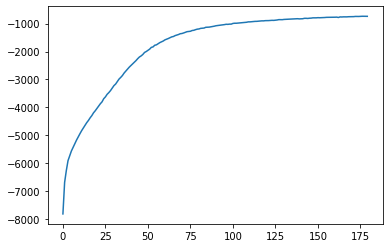

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

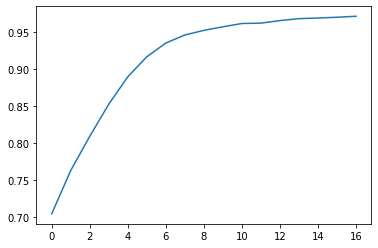

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(accs)
plt.show()

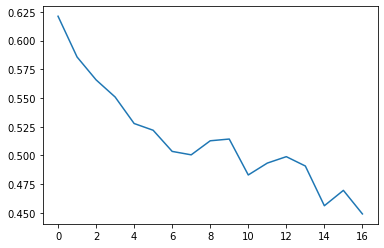

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.array([[j for j in i] for i in correlations]).T[0])
plt.show()

### 1.4.2 More epochs and samples with init results

In [ ]:
# trend
input_size = next(iter(dataloader_weighted))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

EPOCH = 200
ELBOs = []
accs = []
correlations = []
init_acc = helper.check_reconstruct(dataset, standard_vae_weighted)
init_corr = helper.quantitative_assessment(dataset, standard_vae_weighted, experimental_data, 50)
accs.append(init_acc)
correlations.append(init_corr)
print(init_acc, init_corr)
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train(standard_vae_weighted, dataloader_weighted, Adam(standard_vae_weighted.parameters(), lr=1e-4), DEVICE))
    if epoch in range(0, EPOCH, 10):
        acc = helper.check_reconstruct(dataset, standard_vae_weighted)
        accs.append(acc)
        correlation = helper.quantitative_assessment(dataset, standard_vae_weighted, experimental_data, 50)
        correlations.append(correlation) 
        print(acc, correlation)

0.03858123134972263 SpearmanrResult(correlation=-0.036403834363489054, pvalue=0.010065334920898419)


  0%|          | 1/200 [02:59<9:56:21, 179.80s/it]

0.525011003542462 SpearmanrResult(correlation=0.5837049496745788, pvalue=0.0)


  6%|▌         | 11/200 [06:37<3:07:24, 59.50s/it]

0.7004472188667612 SpearmanrResult(correlation=0.6374792869176791, pvalue=0.0)


 10%|█         | 21/200 [10:15<2:54:13, 58.40s/it]

0.7583496043572089 SpearmanrResult(correlation=0.6064501686107556, pvalue=0.0)


 16%|█▌        | 31/200 [13:52<2:44:24, 58.37s/it]

0.8031189953135573 SpearmanrResult(correlation=0.5937562405074264, pvalue=0.0)


 20%|██        | 41/200 [17:27<2:33:17, 57.85s/it]

0.8468665595073516 SpearmanrResult(correlation=0.5630360924645673, pvalue=0.0)


 26%|██▌       | 51/200 [21:02<2:23:30, 57.79s/it]

0.8814651871183904 SpearmanrResult(correlation=0.5685878084551745, pvalue=0.0)


 30%|███       | 61/200 [24:39<2:14:37, 58.11s/it]

0.9105664061363896 SpearmanrResult(correlation=0.5513048908825091, pvalue=0.0)


 36%|███▌      | 71/200 [28:15<2:04:45, 58.03s/it]

0.9294852281077979 SpearmanrResult(correlation=0.5520047479936762, pvalue=0.0)


 40%|████      | 81/200 [31:52<1:55:55, 58.45s/it]

0.9411460746922401 SpearmanrResult(correlation=0.5289219033141273, pvalue=0.0)


 46%|████▌     | 91/200 [35:30<1:46:31, 58.63s/it]

0.9472843063308664 SpearmanrResult(correlation=0.5451084044172844, pvalue=0.0)


 50%|█████     | 101/200 [39:07<1:36:12, 58.30s/it]

0.9550740388139054 SpearmanrResult(correlation=0.5438772558669572, pvalue=0.0)


 56%|█████▌    | 111/200 [42:45<1:26:51, 58.56s/it]

0.9585593018228071 SpearmanrResult(correlation=0.5361914695510925, pvalue=0.0)


 60%|██████    | 121/200 [46:22<1:16:37, 58.19s/it]

0.9618826624888753 SpearmanrResult(correlation=0.534565644080348, pvalue=0.0)


 66%|██████▌   | 131/200 [49:58<1:06:50, 58.12s/it]

0.9634154026327066 SpearmanrResult(correlation=0.5342536265395087, pvalue=0.0)


 70%|███████   | 141/200 [53:34<57:14, 58.21s/it]  

0.9661847082752456 SpearmanrResult(correlation=0.5380679276413824, pvalue=0.0)


 76%|███████▌  | 151/200 [57:10<47:23, 58.03s/it]

0.9674745949048267 SpearmanrResult(correlation=0.5383584949962852, pvalue=0.0)


 80%|████████  | 161/200 [1:00:47<37:50, 58.22s/it]

0.9691677831788313 SpearmanrResult(correlation=0.5267326020574963, pvalue=0.0)


 86%|████████▌ | 171/200 [1:04:23<28:07, 58.19s/it]

0.9702109383937348 SpearmanrResult(correlation=0.5070575923924429, pvalue=0.0)


 90%|█████████ | 181/200 [1:08:02<18:41, 59.00s/it]

0.9718929777040115 SpearmanrResult(correlation=0.5125444249629463, pvalue=0.0)


 96%|█████████▌| 191/200 [1:11:39<08:44, 58.27s/it]

0.9725643392154619 SpearmanrResult(correlation=0.506858954070154, pvalue=0.0)


100%|██████████| 200/200 [1:12:17<00:00, 21.69s/it]


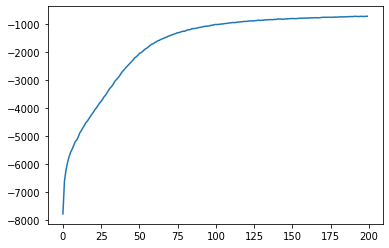

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

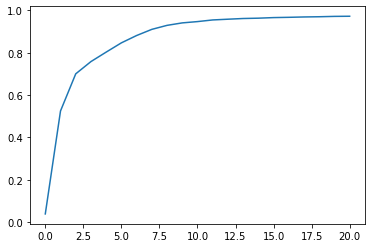

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(accs)
plt.show()

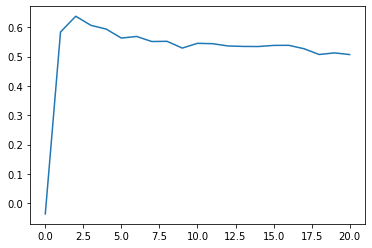

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.array([[j for j in i] for i in correlations]).T[0])
plt.show()

### 1.4.3 Seems overfitting, let's just train 10 epochs

In [ ]:
# unweighted
input_size = next(iter(dataloader))[0].shape[1] * 23
standard_vae = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

EPOCH = 10
ELBOs = []
accs = []
correlations = []
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train(standard_vae, dataloader, Adam(standard_vae.parameters(), lr=1e-4), DEVICE))
    if epoch in range(0, EPOCH, 2):
        acc = helper.check_reconstruct(dataset, standard_vae)
        accs.append(acc)
        correlation = helper.quantitative_assessment(dataset, standard_vae, experimental_data, 100)
        correlations.append(correlation)
        print(acc, correlation)

 10%|█         | 1/10 [05:49<52:21, 349.01s/it]

0.6016305601821063 SpearmanrResult(correlation=0.6113284639669914, pvalue=0.0)


 30%|███       | 3/10 [11:42<27:53, 239.10s/it]

0.6817252003420308 SpearmanrResult(correlation=0.593401085026026, pvalue=0.0)


 50%|█████     | 5/10 [17:36<18:18, 219.65s/it]

0.7268440870743762 SpearmanrResult(correlation=0.5682762617484144, pvalue=0.0)


 70%|███████   | 7/10 [23:29<10:38, 212.68s/it]

0.7514774800627444 SpearmanrResult(correlation=0.5525061836537879, pvalue=0.0)


 90%|█████████ | 9/10 [29:23<03:29, 209.81s/it]

0.7700186914800589 SpearmanrResult(correlation=0.5423959622054667, pvalue=0.0)


100%|██████████| 10/10 [29:27<00:00, 176.77s/it]


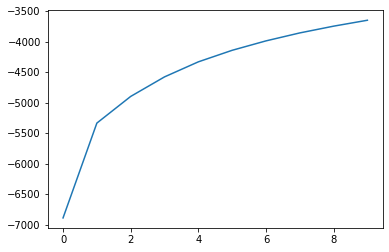

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

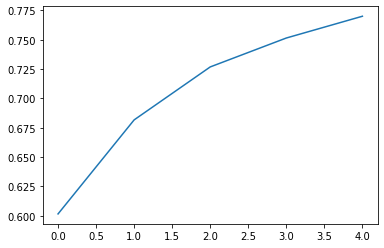

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(accs)
plt.show()

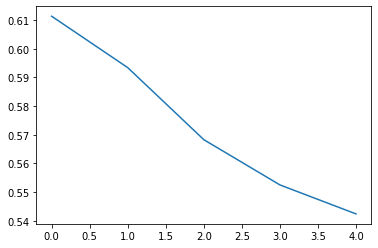

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.array([[j for j in i] for i in correlations]).T[0])
plt.show()

In [ ]:
# weighted
input_size = next(iter(dataloader_weighted))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

EPOCH = 10
ELBOs = []
accs = []
correlations = []
count = 0
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train(standard_vae_weighted, dataloader_weighted, Adam(standard_vae_weighted.parameters(), lr=1e-4), DEVICE))
    if epoch in range(0, EPOCH, 2):
        acc = helper.check_reconstruct(dataset, standard_vae_weighted)
        accs.append(acc)
        correlation = helper.quantitative_assessment(dataset, standard_vae_weighted, experimental_data, 100)
        correlations.append(correlation) 
        print(acc, correlation)

 10%|█         | 1/10 [05:50<52:35, 350.56s/it]

0.5131378419096333 SpearmanrResult(correlation=0.6266905504743042, pvalue=0.0)


 30%|███       | 3/10 [11:45<28:00, 240.05s/it]

0.6022219399972467 SpearmanrResult(correlation=0.6601430649801059, pvalue=0.0)


 50%|█████     | 5/10 [17:40<18:22, 220.47s/it]

0.6349611143534667 SpearmanrResult(correlation=0.6614006479622457, pvalue=0.0)


 70%|███████   | 7/10 [23:36<10:40, 213.66s/it]

0.65837975503303 SpearmanrResult(correlation=0.6667878030341958, pvalue=0.0)


 90%|█████████ | 9/10 [29:29<03:30, 210.30s/it]

0.6838614387398375 SpearmanrResult(correlation=0.6617398075693872, pvalue=0.0)


100%|██████████| 10/10 [29:33<00:00, 177.39s/it]


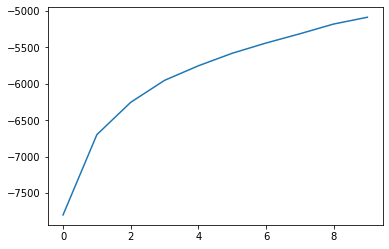

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

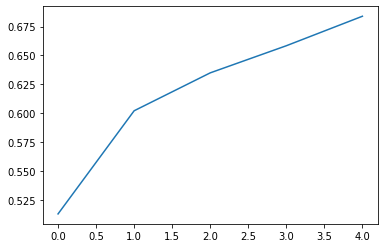

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(accs)
plt.show()

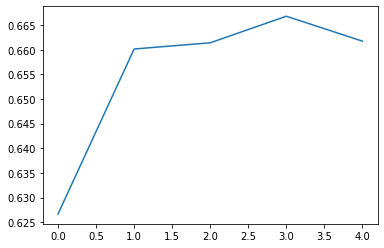

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(np.array([[j for j in i] for i in correlations]).T[0])
plt.show()

In [ ]:
# if correlation < correlations[-1] and len(correlations)>0:
#     count += 1
#     if count > 3:
#         break
# else:
#     correlations.append(correlation)

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/" + "standard_vae_weighted.pkl"
# #torch.save(standard_vae_weighted.state_dict(),PATH)
# standard_vae_weighted.load_state_dict(torch.load(PATH))